# Método do painel vórtice-fonte

- PET - Física
- Petiano: Gabriel Wendell Celestino Rocha
- Data: 13 de Julho de 2022

O objetivo deste `Notebook` é apresentar o método do *painel vórtice-fonte* para tratar de corpos que possuem sustentação. Além disso, este Notebook serve como uma continuação do Notebook: [Método do painel de fontes para corpos sem sustentação](https://github.com/GabrielWendell/PET.py/blob/main/Notebooks/Método%20do%20painel%20de%20fontes%20para%20corpos%20sem%20sustentação.ipynb) [1] e faz parte da série de Notebooks escritos por mim relativos à Aerodinâmica Clássica Computacional.

Para uma melhor organização deste `Notebook` como um todo, este foi dividido em quatro seções:

1. **Método de painel para corpos em sustentação**;
2. **Exercício: Derivação do método do painel vórtice-fonte**;
3. **Aerofólio de elementos múltiplos 2D**.

## Pré-requisitos

Este `Notebook` faz parte da série de `Notebooks` relativos à *Dinâmica dos Fluídos e Aerodinâmica* escritos por mim. Em particular, faz parte da série que visa servir como uma breve introdução à Aerodinâmica Clássica Computacional. Dessa forma, é recomendável que o leitor tenha lido ao menos o `Notebook` [Método do painel de fontes para corpos sem sustentação](https://github.com/GabrielWendell/PET.py/blob/main/Notebooks/Método%20do%20painel%20de%20fontes%20para%20corpos%20sem%20sustentação.ipynb) [1] (que por sua vez depende dos outros três `Notebooks` de Dinâmica dos Fluídos/Aerodinâmica anteriores) para facilitar a compreensão dos conceitos abordados neste `Notebook`.

### Importando as bibliotecas

A função `opt_plot()` é praticamente onipresente em todos os `Notebooks` que eu escrevo. Por isso, vamos defini-lá logo no ínicio junto com as bibliotecas necessárias.

In [1]:
from scipy import integrate, linalg
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib notebook

def opt_plot():
    # plt.style.use('dark_background')
    plt.grid(True, linestyle=':', color='0.50')
    plt.minorticks_on()
    plt.tick_params(axis = 'both', which = 'minor', direction = "in",
                        top = True, right = True, length = 5, width = 1, labelsize = 15)
    plt.tick_params(axis = 'both', which = 'major', direction = "in",
                        top = True, right = True, length = 8, width = 1, labelsize = 15)

Curiosamente, na contramão dos outros `Notebooks`, para a realização deste em particular será necessário uma quantidade muito diminuta de bibliotecas que serão apenas as bibliotecas fundamentais necessárias para a realização de qualquer `Notebook`. Note que precisamos apenas do básico para trabalhar com Aerodinâmica Clássica.

#### Detalhes das bibliotecas:

In [2]:
%load_ext version_information
%version_information Matplotlib, Numpy, Scipy

Software versions
Python 3.9.8 64bit [MSC v.1929 64 bit (AMD64)]
IPython 8.0.1
OS Windows 10 10.0.19043
Matplotlib 3.5.1
Numpy 1.22.2
Scipy 1.8.0
Wed Jul 13 12:02:44 2022 Hora Padrão de Buenos Aires

Para instalar a magic extension `%version_information` do `IPython` usando o `pip`, execute a seguinte linha de comando em um terminal de sua preferência:

```
$ pip install version_information
```

Dado o exposto, vamos ao `Notebook` propriamente dito.

---

## 1. Método de painel para corpos em sustentação

Se simplesmente aumentarmos o ângulo de ataque no fluxo livre e calcularmos o fluxo apenas com uma folha de fonte, o ponto de estagnação traseiro não estará localizado na borda de fuga. Em vez disso, o fluxo se curvará ao redor da borda de fuga e o ponto de estagnação estará em algum lugar na superfície superior do aerofólio. Esta não é uma solução fisicamente possível.

Por exemplo, usando o método de painel de folha de fonte da [`Notebook`](https://github.com/GabrielWendell/PET.py/blob/main/Notebooks/Método%20do%20painel%20de%20fontes%20para%20corpos%20sem%20sustentação.ipynb) [1] com um ângulo de ataque |$\alpha=4^{\circ}$ (usando 40 painéis) e plotando as linhas de corrente em uma área próxima à borda de fuga, obtemos o seguinte gráfico:

![image](https://media.giphy.com/media/weli3EeUaCIPIJoWtO/giphy.gif)

Como você pode ver, as linhas de corrente se comportam de forma estranha na borda de fuga. Sabemos experimentalmente que o fluxo deixa a borda de fuga de um aerofólio suavemente, então isso deve estar errado. O que há de errado? Não podemos usar exclusivamente fontes para calcular o fluxo potencial de um aerofólio com ângulo de ataque diferente de zero - precisamos de circulação. Mas como obter circulação?

### 1.1 A condição de Kutta

A *condição de Kutta* afirma que a pressão abaixo e acima do bordo de fuga do aerofólio deve ser igual para que o fluxo não se curve em torno dele e, em vez disso, deixe o aerofólio tangencialmente. O ponto de estagnação traseiro deve estar exatamente na borda de fuga.

É natural ficar um pouco perplexo com isso. Como podemos justificar essa condição aparentemente arbitrária? Lembre-se de que a teoria do fluxo potencial ignora completamente a viscosidade do fluido, portanto, se estivermos deixando de fora esse efeito físico, não devemos nos surpreender que a teoria precise de algum ajuste para aquelas situações em que a viscosidade desempenha um papel. Um fluido viscoso real não é capaz de virar um canto afiado como uma borda de fuga de aerofólio sem se separar lá. A condição de Kutta nos permite corrigir a teoria do fluxo potencial para que ela dê uma solução mais próxima da realidade.

Lembre-se do `Notebook` [Vórtices potenciais e sustentação aerodinâmica](https://github.com/GabrielWendell/PET.py/blob/main/Notebooks/Vórtices%20potenciais%20e%20sustentação%20aerodinâmica.ipynb) [2], onde estudamos a sustentação em um cilindro combinando um gibão e um fluxo livre, além de um vórtice. Foi quando aprendemos que a **elevação sempre requer circulação**. Se você experimentou a circulação do vórtice de pontos (o que você fez, certo?), você descobriu que os pontos de estagnação se moviam ao longo do cilindro.

Como no cilindro circular, a quantidade de circulação que adicionamos a um aerofólio moverá os pontos de estagnação ao longo da superfície. E se adicionarmos a quantidade certa, o ponto de estagnação traseiro pode coincidir com a borda de fuga. Essa quantidade de circulação torna o fluxo uma solução fisicamente relevante. E essa quantidade dá a sustentação correta!

Para implementar a condição de Kutta em nosso método de painel, precisamos adicionar mais uma equação ao sistema, fornecendo a circulação que move o ponto de estagnação para o bordo de fuga. Colocando uma folha de vórtice com a mesma força constante em cada painel, podemos adicionar a circulação ao fluxo com apenas mais uma incógnita.

Como aplicamos isso em nosso código? Podemos reutilizar a maior parte do código da seção 4 deste [`Notebook`](https://github.com/GabrielWendell/PET.py/blob/main/Notebooks/Método%20do%20painel%20de%20fontes%20para%20corpos%20sem%20sustentação.ipynb) [1] e aplicar a condição Kutta enquanto adicionamos circulação ao fluxo. Anteriormente, discretizamos a geometria em N painéis, com uma força de fonte constante em cada um (variando de painel para painel), e aplicamos uma condição de contorno de Neumann de tangência de fluxo nos N centros dos painéis. Isso levou a um sistema linear de `N` equações e `N` incógnitas que resolvemos com a função SciPy [`linalg.solve`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve.html). No caso do corpo de elevação, teremos `N+1` equações e `N+1` incógnitas. Leia mais para descobrir como!

### 1.2 Discretização em painéis

Começamos importando a geometria do aerofólio NACA0012 do arquivo de dados `naca0012.dat`:

In [3]:
naca_filepath = os.path.join('Dados/NACA0012', 'naca0012.dat')
with open(naca_filepath, 'r') as infile:
    x, y = np.loadtxt(infile, dtype=float, unpack=True)

Agora traçamos a geometria do nosso aerofólio:

<IPython.core.display.Javascript object>


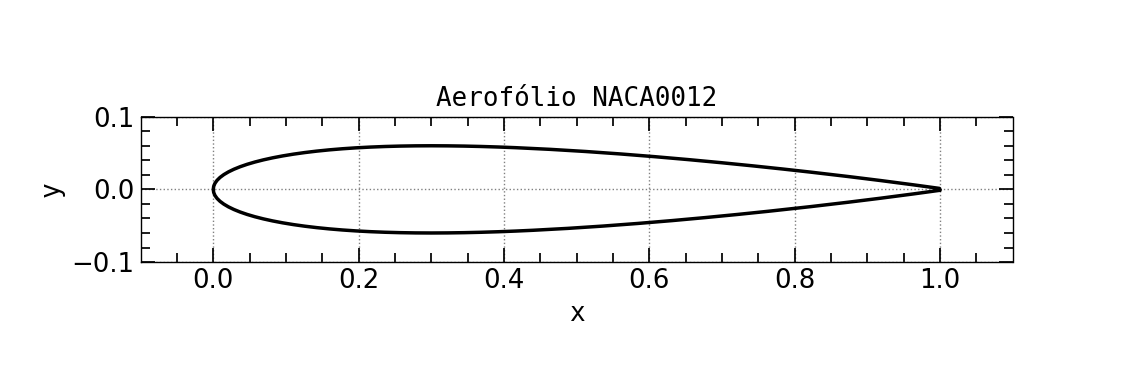

In [4]:
plt.figure(figsize = (9, 3))

plt.plot(x, y, color = 'black', linestyle = '-', linewidth = 2)
plt.axis('scaled')

plt.title('Aerofólio NACA0012', fontsize = 15, family = 'monospace')
plt.xlabel('x', fontsize = 15, family = 'monospace')
plt.ylabel('y', fontsize = 15, family = 'monospace')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.1)

opt_plot()
plt.savefig('Aerofólio NACA0012.png', dpi = 400)

O contorno que define o aerofólio será particionado em `N` painéis, usando o mesmo método presente no [`Notebook`](https://github.com/GabrielWendell/PET.py/blob/main/Notebooks/Método%20do%20painel%20de%20fontes%20para%20corpos%20sem%20sustentação.ipynb) [1].

Definimos uma classe `Panel` que armazenará todas as informações sobre um painel: pontos inicial e final, ponto central, comprimento, orientação, força da fonte, velocidade tangencial e coeficiente de pressão. Não economizamos a força da folha de vórtice porque todos os painéis terão o mesmo valor.

In [5]:
class Panel:
    """
    Contém informações relacionadas ao painel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Inicializa o painel.
        
        Define os pontos finais e calcula o ponto central, comprimento e o ângulo (com o eixo x) do painel.
        Define se o painel está localizado na superfície superior ou inferior da geometria.
        Inicializa a força da fonte, a velocidade tangencial e o coeficiente de pressão do painel para zero.
        
        Parâmetros
        ----------
        xa: float
            Coordenada x do primeiro ponto final.
        ya: float
            Coordenada y do primeiro ponto final.
        xb: float
            Coordenada x do segundo ponto final.
        yb: float
            Coordenada y do segundo ponto final.
        """
        self.xa, self.ya = xa, ya  
        self.xb, self.yb = xb, yb  
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2  
        self.length = np.sqrt((xb - xa)**2 + (yb - ya)**2)  
        
        # Orientação do painel (ângulo entre o eixo x e o normal do painel)
        if xb - xa <= 0.0:
            self.beta = np.arccos((yb - ya) / self.length)
        elif xb - xa > 0.0:
            self.beta = np.pi + np.arccos(-(yb - ya) / self.length)
        
        # Localização do painel
        if self.beta <= np.pi:
            self.loc = 'upper'  
        else:
            self.loc = 'lower'  
        
        self.sigma = 0.0  
        self.vt = 0.0  
        self.cp = 0.0  

Como antes, chamamos a função `define_panels` para discretizar a geometria do aerofólio em `N` painéis. A função retornará um array NumPy de `N` objetos do tipo `Panel`.

In [6]:
def define_panels(x, y, N = 40):
    """
    Discretiza a geometria em painéis usando o método 'coseno'.
    
    Parâmetros
    ----------
    x: 1D array de floats
        Coordenada x dos pontos que definem a geometria.
    y: 1D array de floats
        Coordenada y dos pontos que definem a geometria.
    N: integer, opcional
        Número de painéis;
        Padrão: 40.
    
    Retorna
    -------
    panels: 1D Numpy array de objetos Panel 
        A discretização da geometria em painéis.
    """
    R = (x.max() - x.min()) / 2  
    x_center = (x.max() + x.min()) / 2  
    x_circle = x_center + R * np.cos(np.linspace(0.0, 2 * np.pi, N + 1))
    
    x_ends = np.copy(x_circle)  
    y_ends = np.empty_like(x_ends)  

    x, y = np.append(x, x[0]), np.append(y, y[0])  
    
    # Calcula a coordenada y dos pontos finais
    I = 0
    for i in range(N):
        while I < len(x) - 1:
            if (x[I] <= x_ends[i] <= x[I + 1]) or (x[I + 1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I + 1] - y[I]) / (x[I + 1] - x[I])
        b = y[I + 1] - a * x[I + 1]
        y_ends[i] = a * x_ends[i] + b
    y_ends[N] = y_ends[0]
    
    panels = np.empty(N, dtype = object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i + 1])
    
    return panels

Agora podemos usar nossa nova função para definir a geometria dos painéis do aerofólio e, em seguida, plotar os nós do painel na geometria.

In [7]:
panels = define_panels(x, y, N = 40)

Podemos então plotar a geometria discretizada:

<IPython.core.display.Javascript object>


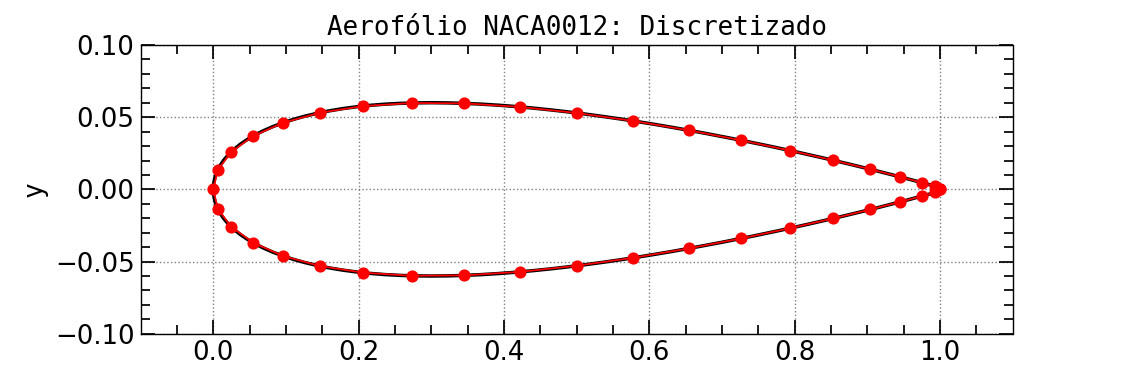

In [8]:
plt.figure(figsize = (9, 3))

plt.plot(x, y, color = 'black', linestyle = '-', linewidth = 2)
plt.plot(np.append([panel.xa for panel in panels], panels[0].xa),
            np.append([panel.ya for panel in panels], panels[0].ya),
            linestyle = '-', linewidth = 1, marker = 'o', markersize = 6, color = 'red')

plt.title('Aerofólio NACA0012: Discretizado', fontsize = 15, family = 'monospace')
plt.xlabel('x', fontsize = 15, family = 'monospace')
plt.ylabel('y', fontsize = 15, family = 'monospace')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.1)

opt_plot()
plt.savefig('Aerofólio NACA0012 - Discretizado.png', dpi = 400)

### 1.3 Condições de fluxo livre

O aerofólio está imerso em uma corrente livre $(U_{\infty},\alpha)$ onde $U_{\infty}$ e $\alpha$ são a magnitude da velocidade e o ângulo de ataque, respectivamente. Como antes, criamos uma classe para o fluxo livre, mesmo que tenhamos apenas um objeto que use essa classe. Torna mais fácil passar o fluxo gratuito para outras funções posteriormente.

In [9]:
class Freestream:
    """
    Condições de fluxo livre
    """
    def __init__(self, u_inf = 1.0, alpha = 0.0):
        """
        Define a velocidade do fluxo livre e 
        o ângulo de ataque (em graus).
        
        Parâmetros
        ----------
        u_inf: float, opcional
            Velocidade do fluxo livre;
            default: 1.0.
        alpha: float, opcional
            Ângulo de ataque em graus;
            default 0.0.
        """
        self.u_inf = u_inf
        self.alpha = np.radians(alpha)  

Agora estabelecemos as condições de fluxo livre:

In [10]:
freestream = Freestream(u_inf = 1.0, alpha = 4.0)

### 1.4 Condição de contorno para a tangência do fluxo 

Uma força de vórtice constante $\gamma$ será adicionada a cada painel (todos os painéis têm a mesma força de folha de vórtice constante). Assim, usando o princípio da superposição, o potencial de velocidade se torna:

$$\phi\left(x_{c_i},y_{c_i}\right) = V_\infty x_{c_i} \cos \alpha + V_\infty y_{c_i} \sin \alpha+ \sum_{j=1}^N \frac{\sigma_j}{2\pi} \int_j \ln \left\{\sqrt{[x_{c_i}-x_j(s_j)]^2+[y_{c_i}-y_j(s_j)]^2} \right\} {\rm d}s_j- \sum_{j=1}^N \frac{\gamma}{2\pi} \int_j \tan^{-1} \left[\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right] {\rm d}s_j$$

A condição de contorno para tangência do fluxo é aplicada em cada centro do painel:

$$0 = \vec{V}\cdot\vec{n}_i = \frac{\partial}{\partial n_i} \left\{ \phi\left(x_{c_i},y_{c_i}\right) \right\}$$

Em outras palavras, temos que

$$0 = V_\infty \cos \left(\alpha-\beta_i\right) + \frac{\sigma_i}{2}+ \sum_{j=1,j\neq i}^N \frac{\sigma_j}{2\pi} \int_j \frac{\partial}{\partial n_i} \ln \left\{\sqrt{[x_{c_i}-x_j(s_j)]^2+[y_{c_i}-y_j(s_j)]^2} \right\} {\rm d}s_j- \sum_{j=1,j\neq i}^N \frac{\gamma}{2\pi} \int_j \frac{\partial}{\partial n_i} \tan^{-1} \left[\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right] {\rm d}s_j$$

Já trabalhamos a primeira integral no [`Notebook`](https://github.com/GabrielWendell/PET.py/blob/main/Notebooks/Método%20do%20painel%20de%20fontes%20para%20corpos%20sem%20sustentação.ipynb) [1], dessa forma:

$$\frac{\partial}{\partial n_i} \ln \left\{\sqrt{[x_{c_i}-x_j(s_j)]^2+[y_{c_i}-y_j(s_j)]^2} \right\} = \frac{\left(x_{c_i}-x_j\right)\frac{\partial x_{c_i}}{\partial n_i} + \left(y_{c_i}-y_j\right)\frac{\partial y_{c_i}}{\partial n_i}}{\left(x_{c_i}-x_j\right)^2 + \left(y_{c_i}-y_j\right)^2}$$

onde $\frac{\partial x_{c_i}}{\partial n_i} = \cos \beta_i$ e $\frac{\partial y_{c_i}}{\partial n_i} = \sin \beta_i$. Além disso, temos que

$$x_j(s_j) = x_{b_j} - s_j \sin \beta_j$$

$$y_j(s_j) = y_{b_j} + s_j \cos \beta_j$$

Agora precisamos derivar a última integral da equação de contorno:

$$\boxed{\frac{\partial}{\partial n_i} \tan^{-1} \left[\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right]= \frac{\left(x_{c_i}-x_j\right)\frac{\partial y_{c_i}}{\partial n_i} - \left(y_{c_i}-y_j\right)\frac{\partial x_{c_i}}{\partial n_i}}{\left(x_{c_i}-x_j\right)^2 + \left(y_{c_i}-y_j\right)^2}}$$

onde $\frac{\partial x_{c_i}}{\partial n_i} = \cos \beta_i$ e $\frac{\partial y_{c_i}}{\partial n_i} = \sin \beta_i$.

### 1.5 Reforçando a condição de Kutta

Para impor a condição de Kutta, afirmamos que o coeficiente de pressão no primeiro painel deve ser igual ao do último painel:

$$C_{p_1} = C_{p_{N}}$$

Usando a definição para o coeficiente de pressão:

$$C_p = 1-\left(\frac{V}{U_\infty}\right)^2.$$

A condição de Kutta implica que a magnitude da velocidade no centro do primeiro painel deve ser igual à magnitude do centro do último painel:

$$V_1^2 = V_N^2$$

Como a condição de tangência do fluxo requer que $V_{n_1}=V_{n_N}=0$, acabamos com a seguinte condição de Kutta:

$$V_{t_1} = - V_{t_N}$$

onde o sinal de menos vem do eixo de referência que escolhemos para os vetores normal e tangencial.

Vamos derivar a velocidade tangencial para cada painel, pois será útil calcular o coeficiente de pressão.

$$V_{t_i} = \frac{\partial}{\partial t_i} \left(\phi\left(x_{c_i},y_{c_i}\right)\right)$$

Em outras palavras...

$$V_{t_i} = V_\infty \sin \left(\alpha-\beta_i\right) + \sum_{j=1,j\neq i}^N \frac{\sigma_j}{2\pi} \int_j \frac{\partial}{\partial t_i} \ln \left\{\sqrt{[x_{c_i}-x_j(s_j)]^2+[y_{c_i}-y_j(s_j)]^2} \right\} {\rm d}s_j - \sum_{j=1,j\neq i}^N \frac{\gamma}{2\pi} \int_j \frac{\partial}{\partial t_i} \tan^{-1} \left[\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right] {\rm d}s_j -\frac{\gamma}{2}$$

o que por sua vez nos dá

$$\boxed{V_{t_i} = V_\infty \sin \left(\alpha-\beta_i\right) + \sum_{j=1,j\neq i}^N \frac{\sigma_j}{2\pi} \int_j \frac{\left(x_{c_i}-x_j\right)\frac{\partial x_{c_i}}{\partial t_i} + \left(y_{c_i}-y_j\right)\frac{\partial y_{c_i}}{\partial t_i}}{\left(x_{c_i}-x_j\right)^2 + \left(y_{c_i}-y_j\right)^2} {\rm d}s_j- \sum_{j=1,j\neq i}^N \frac{\gamma}{2\pi} \int_j \frac{\left(x_{c_i}-x_j\right)\frac{\partial y_{c_i}}{\partial t_i} - \left(y_{c_i}-y_j\right)\frac{\partial x_{c_i}}{\partial t_i}}{\left(x_{c_i}-x_j\right)^2 + \left(y_{c_i}-y_j\right)^2} {\rm d}s_j -\frac{\gamma}{2}}$$

onde $\frac{\partial x_{c_i}}{\partial t_i} = -\sin \beta_i$ e $\frac{\partial y_{c_i}}{\partial t_i} = \cos \beta_i$.

### 1.6 Construindo o sistema linear

Aqui, construímos e resolvemos o sistema linear de equações da forma:

$$[A][\sigma,\gamma] = [b]$$

onde a matriz $[A]$ de ordem $N+1\times N+1$ contém três blocos: uma matriz de fonte $N\times N$ (a mesma usada no [`Notebook`](https://github.com/GabrielWendell/PET.py/blob/main/Notebooks/Método%20do%20painel%20de%20fontes%20para%20corpos%20sem%20sustentação.ipynb) [1]), uma matriz de vórtices $N\times1$ para armazenar o peso da variável $\gamma$ em cada painel, e uma matriz Kutta $1×\times N+1$ que representa nossa condição Kutta.

Vamos reutilizar a integral da função do [`Notebook`](https://github.com/GabrielWendell/PET.py/blob/main/Notebooks/Método%20do%20painel%20de%20fontes%20para%20corpos%20sem%20sustentação.ipynb) [1] para calcular as diferentes integrais com a função SciPy [`integrate.quad`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html):

In [11]:
def integral(x, y, panel, dxdk, dydk):
    """
    Calcula a contribuição de um painel em um dado ponto.
    
    Parâmetros
    ----------
    x: float
        Coordenada em x do ponto alvo.
    y: float
        Coordenada em y do ponto alvo.
    panel: Panel object
        Painel cuja contribuição está sendo calculada.
    dxdk: float
        Valor da derivada de x em uma certa direção.
    dydk: float
        Valor da derivada de y em uma certa direção.
    
    Retorna
    -------
    Contribuição do painel em um dado ponto (x, y).
    """
    def integrand(s):
        return (((x - (panel.xa - np.sin(panel.beta) * s)) * dxdk +
                 (y - (panel.ya + np.cos(panel.beta) * s)) * dydk) /
                ((x - (panel.xa - np.sin(panel.beta) * s))**2 +
                 (y - (panel.ya + np.cos(panel.beta) * s))**2) )
    
    return integrate.quad(integrand, 0.0, panel.length)[0]

Primeiro definimos a função `source_contribution_normal` para construir a matriz da fonte, ou seja, o peso de cada fonte na velocidade normal de cada painel:

In [16]:
def source_contribution_normal(panels):
    """
    Constrói a matriz de contribuição da fonte para a velocidade normal.
    
    Parâmetros
    ----------
    panels: 1D array de objetos Panel
        Lista de paineis.
    
    Retorna
    -------
    A: 2D Numpy array de floats
        Matriz de contribuição da fonte.
    """
    A = np.empty((panels.size, panels.size), dtype=float)
    # contribuição da fonte em um painel de si mesmo
    np.fill_diagonal(A, 0.5)
    # contribuição da fonte em um painel de outros
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / np.pi * integral(panel_i.xc, panel_i.yc, 
                                                    panel_j,
                                                    np.cos(panel_i.beta),
                                                    np.sin(panel_i.beta))
    return A

Então, definimos `vortex_contribution_normal` para construir a matriz vórtice:

In [17]:
def vortex_contribution_normal(panels):
    """
     Constrói a matriz de contribuição do vórtice para a velocidade normal.
    
    Parâmetros
    ----------
    panels: 1D array de objetos Panel
        Lista de paineis.
    
    Retorna
    -------
    A: 2D Numpy array de floats
        Matriz de contribuição do vórtice
    """
    A = np.empty((panels.size, panels.size), dtype=float)
    # contribuição do vórtice em um painel de si mesmo
    np.fill_diagonal(A, 0.0)
    # contribuição do vórtice em um painel de outros
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5 / np.pi * integral(panel_i.xc, panel_i.yc, 
                                                     panel_j,
                                                     np.sin(panel_i.beta),
                                                     -np.cos(panel_i.beta))
    return A

Vamos chamar essas duas funções para criar a matriz da fonte `A_source` e a matriz de vórtice `B_vortex`:

In [18]:
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)

Ainda temos que incluir a condição Kutta em nosso sistema

Após esta parte mais explicativa, há um exercício para o leitor interessado, que o ajudará a mostrar que:

- a matriz resultante da contribuição dos vórtices na velocidade normal, $B_n$, é exatamente a matriz resultante da **contribuição** das fontes na velocidade tangencial, $A_t$, ou seja.

$$B^n_{ij}=A^t_{ij} \quad \forall (i, j) \in \{1, \cdots, N\}^2$$

- a matriz resultante da contribuição dos vórtices na velocidade tangencial, $B_t$, é o **oposto** da matriz resultante da contribuição das fontes na velocidade normal, $A_n$, ou seja.

$$B^t_{ij}=-A^n_{ij} \quad \forall (i, j) \in \{1, \cdots, N\}^2$$

onde os sobrescritos $n$ e $t$ denotam as componentes da velocidade normal e tangencial, respectivamente.

Assim, a condição de Kutta pode ser lançada da seguinte forma:

$$\begin{bmatrix}
(A^t_{11}+A^t_{N1}) \\
\vdots \\ 
(A^t_{1N}+A^t_{NN}) \\
\left[ \sum_{j=1}^N (B^t_{1j}+B^t_{Nj}) \right]
\end{bmatrix}^T
\begin{bmatrix}
\sigma_1 \\
\vdots \\
\sigma_N \\
\gamma
\end{bmatrix} = -(b^t_1+b^t_N)$$

Vamos definir uma função chamada `kutta_condition` que faz o trabalho:

In [19]:
def kutta_condition(A_source, B_vortex):
    """
    Constrói a matriz de condição Kutta.
    
    Parâmetros
    ----------
    A_source: 2D Numpy array de floats
        Matriz de contribuição da fonte para a velocidade normal.
    B_vortex: 2D Numpy array de floats
        Matriz de contribuição o vórtice para a velocidade normal.
    
    Retorna
    -------
    b: 1D Numpy array de floats
        O lado esquerdo da equação da condição de Kutta.
    """
    b = np.empty(A_source.shape[0] + 1, dtype = float)
    # A matriz de contribuição da fonte na velocidade tangencial 
    # é a mesma que matriz de contribuição do vórtice na velocidade normal
    b[:-1] = B_vortex[0, :] + B_vortex[-1, :]
    # A matriz de contribuição do vórtice na velocidade tangencial 
    # é o oposto da matriz de contribuição do vórtice na velocidade normal
    b[-1] = - np.sum(A_source[0, :] + A_source[-1, :])
    
    return b

Agora temos todos os ingredientes que precisamos. A função `build_singularity_matrix` reunirá a matriz da fonte, a matriz de vórtices e a matriz de Kutta para construir a matriz necessária para resolver o sistema linear.

In [27]:
def build_singularity_matrix(A_source, B_vortex):
    """
    Constrói a matriz do lado esquerdo do sistema decorrente das contribuições da fonte e do vórtice.
    
    Parâmetros
    ----------
    A_source: 2D Numpy array of floats
        Matriz de contribuição da fonte para a velocidade normal.
    B_vortex: 2D Numpy array of floats
        Matriz de contribuição do vórtice para a velocidade normal.
    
    Retorna
    -------
    A:  2D Numpy array de floats
        Matriz de sistema linear.
    """
    A = np.empty((A_source.shape[0] + 1, A_source.shape[1] + 1), dtype=float)
    # Array de contribuição da fonte
    A[:-1, :-1] = A_source
    # Array de contribuição do vórtice
    A[:-1, -1] = np.sum(B_vortex, axis = 1)
    # Array da condição de Kutta
    A[-1, :] = kutta_condition(A_source, B_vortex)
    
    return A

No lado direito, armazenamos tudo o que não depende das forças desconhecidas.

In [25]:
def build_freestream_rhs(panels, freestream):
    """
    Constrói o lado direito do sistema 
    decorrente da contribuição freestream.
    
    Parâmetros
    ----------
    panels: 1D array de obejtos Panel
        Lista de paineis.
    freestream: Objeto freestream 
        Freestream conditions.
    
    Retorna
    -------
    b: 1D Numpy array de floats
        Contribuição Freestream em cada painel e na condição Kutta.
    """
    b = np.empty(panels.size + 1, dtype = float)
    # Contribuição freestream em cada painel
    for i, panel in enumerate(panels): 
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - panel.beta)
    # Contribuição freestream na condição Kutta
    b[-1] = -freestream.u_inf * (np.sin(freestream.alpha - panels[0].beta) +
                                 np.sin(freestream.alpha - panels[-1].beta))
    
    return b

Agora vamos construir nossas matrizes:

In [26]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels, freestream)

Como no `Notebook` [1], resolvemos o sistema linear usando a função Scipy `linalg.solve`. Em seguida, armazenamos os resultados no atributo sigma de cada objeto `Panel`. Também criamos uma variável `gamma` para armazenar o valor da força constante do vórtice.

In [29]:
# Resolve para pontos fortes de singularidade
strengths = np.linalg.solve(A, b)

# Armazena a força da fonte em cada painel
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
    
# Armazena a densidade de circulação 
gamma = strengths[-1]

### 1.7 Coeficiente de pressão de superfície

O coeficiente de pressão no centro do $i$-ésimo painel é:

$$C_{p_i} = 1 - \left(\frac{V_{t_i}}{U_\infty}\right)^2$$

Então, temos que calcular a velocidade tangencial em cada centro do painel usando a função `compute_tangential_velocity`:

In [32]:
def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    """
    Calcula a velocidade superficial tangencial.
    
    Parâmetros
    ----------
    panels: 1D array de objetos Panel 
        Lista de paineis.
    freestream: Objeto freestream 
        Condições freestream.
    gamma: float
        Circulação de densidade
    A_source: 2D Numpy array de floats
        Matriz de contribuição da fonte para a velocidade normal.
    B_vortex: 2D Numpy array de floats
        Matriz de contribuição do vórtice para a velocidade normal.
    """
    A = np.empty((panels.size, panels.size + 1), dtype=float)
    # matriz de contribuição da fonte na velocidade tangencial 
    # é a mesma que matriz de contribuição do vórtice na velocidade normal
    A[:, :-1] = B_vortex
    # matriz de contribuição do vórtice na velocidade tangencial 
    # é o oposto da matriz de contribuição da fonte na velocidade normal
    A[:, -1] = -np.sum(A_source, axis=1)
    # Contribuição freestream
    b = freestream.u_inf * np.sin([freestream.alpha - panel.beta 
                                      for panel in panels])
    
    strengths = np.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = np.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

Calculemos a velocidade tangencial em cada ponto:

In [34]:
compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)

E definimos uma função `compute_pressure_coeficient` para calcular o coeficiente de pressão da superfície:

In [35]:
def compute_pressure_coefficient(panels, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parâmetros
    ----------
    panels: 1D array de objetos Panel
        Lista de panels.
    freestream: Objeto freestream 
        Condições freestream.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / freestream.u_inf)**2

Calculemos o coeficiente de pressão:

In [36]:
compute_pressure_coefficient(panels, freestream)

Vamos plotar o nosso resultado:

<IPython.core.display.Javascript object>


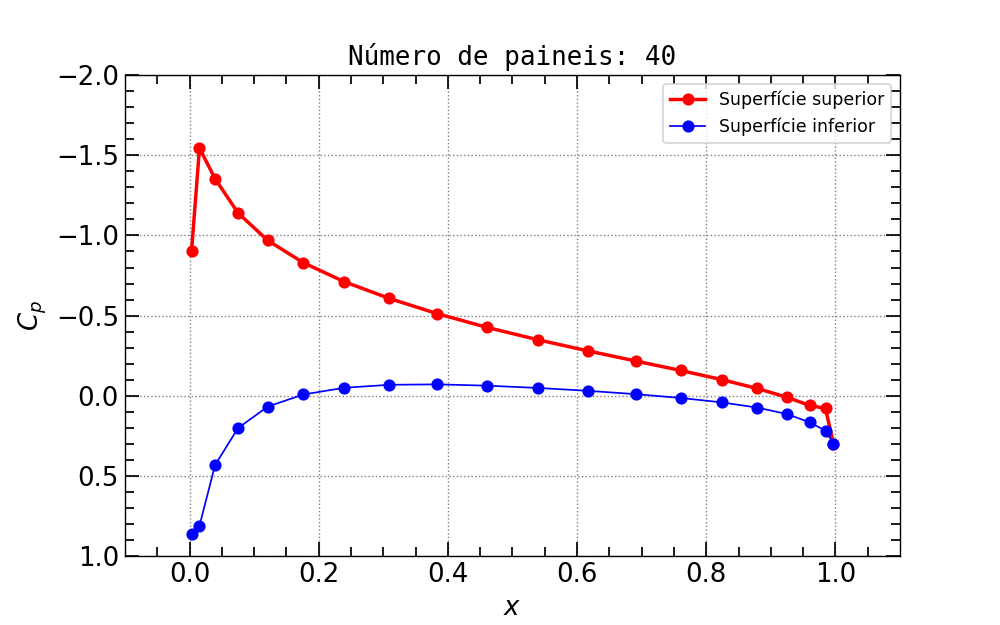

In [43]:
plt.figure(figsize = (8, 5))

plt.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.cp for panel in panels if panel.loc == 'upper'],
            label = 'Superfície superior',
            color = 'red', linestyle = '-', linewidth = 2, marker = 'o', markersize = 6)
plt.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.cp for panel in panels if panel.loc == 'lower'],
            label = 'Superfície inferior',
            color = 'blue', linestyle = '-', linewidth = 1, marker = 'o', markersize = 6)

plt.title('Número de paineis: {}'.format(panels.size), fontsize = 15, family = 'monospace')
plt.xlabel('$x$', fontsize = 15, family = 'monospace')
plt.ylabel('$C_p$', fontsize = 15, family = 'monospace')
plt.xlim(-0.1, 1.1)
plt.ylim(1.0, -2.0)
plt.legend(loc = 'best')

opt_plot()
plt.savefig('Número de paineis.png', dpi = 400)

### 1.8 Verificação de precisão

Para um corpo fechado, a soma de todas as forças da fonte deve ser zero. Caso contrário, significa que o corpo estaria adicionando ou absorvendo massa do fluxo! Portanto, devemos ter

$$\sum_{i=1}^{N} \sigma_i \ell_i = 0$$

onde $\ell_i$ é o comprimento do $i$-ésimo painel.

Com isso, podemos obter uma medida da precisão do método do painel de fontes.

In [40]:
accuracy = sum([panel.sigma * panel.length for panel in panels])
print('Soma das forças de singularidade: {:0.6f}'.format(accuracy))

Soma das forças de singularidade: 0.004606


### 1.9 Coeficiente de sustentação

A sustentação é dada pelo teorema de Kutta-Joukowski, $L=\rho\Gamma U_{\infty}$, onde$\rho$ é a densidade do fluido. A circulação total $\Gamma$ é dada por:

$$\Gamma = \sum_{i=1}^N \gamma \ell_i$$

Finalmente, o coeficiente de sustentação é dado por:

$$\boxed{C_\ell = \frac{\sum_{i=1}^N \gamma \ell_i}{\frac{1}{2}U_\infty c}}$$

com $c$ o comprimento da corda do aerofólio.

In [41]:
c = abs(max(panel.xa for panel in panels) -
        min(panel.xa for panel in panels))
cl = (gamma * sum(panel.length for panel in panels) /
      (0.5 * freestream.u_inf * c))
print('Coeficiente de sustentação: CL = {:0.3f}'.format(cl))

Coeficiente de sustentação: CL = 0.506


#### Para exercitar...

Com base no que foi feito no `Notebook` [1] e na discussão feita até aqui, calcule e plote as linhas de corrente e o coeficiente de pressão em uma grade cartesiana.

---

## 2. Exercício: Derivação do método do painel vórtice-fonte

O potencial no local $(x,y)$ induzido por um fluxo uniforme, uma folha de fonte e uma folha de vórtice pode ser representado como

$$\phi(x,y)=\phi_{\text{fluxo uniforme}}(x, y)+\phi_{\text{folha-fonte}}(x,y)+\phi_{\text{folha-vórtice}}(x,y),$$

$$\boxed{\implies\phi(x,y)=xU_{\infty}\cos(\alpha)+yU_{\infty}\sin(\alpha)+\frac{1}{2\pi} \int_{\text{folha}}\sigma(s)\ln\left[(x-\xi(s))^2+(y-\eta(s))^2\right]^{\frac{1}{2}}ds-\frac{1}{2\pi} \int_{\text{folha}} \gamma(s)\tan^{-1}\Bigg[\frac{y-\eta(s)}{x-\xi(s)}\Bigg]ds}$$

onde $s$ é coordenada local na folha, e $\xi(s)$ e $\eta(s)$ são coordenadas da fonte infinita e vórtice na folha. Na equação acima, assumimos que a folha de fonte e a folha de vórtice se sobrepõem.

### Problema 1.

Se discretizarmos a folha em $N$ painéis, reescreva a equação acima usando a integral discretizada. Suponha que $\ell_j$ represente o comprimento do painel $j$. E para que

$$\left\{
\begin{array}{l}
\xi_j(s)=x_j-s\sin\beta_j \\
\eta_j(s)=y_j+s\cos\beta_j
\end{array}
,\ \ \ 
0\le s \le \ell_j
\right.$$

A figura a seguir mostra o painel $j$:

![image](https://media.giphy.com/media/ICkocs1mWrlEXEfHtE/giphy.gif)

**DICA**: por exemplo, considere a integral $\int_{0}^{L}f(x)dx$, se discretizarmos o domínio $0\sim L$ em $3$ painéis, a integral pode ser escrita como:

$$\int_0^L f(x) dx = \int_0^{L/3} f(x)dx+\int_{L/3}^{2L/3} f(x)dx+\int_{2L/3}^{L} f(x)dx=\sum_{j=1}^3 \int_{l_j}f(x)dx$$

### Problema 2.

A velocidade normal $U_n$ pode ser derivada da regra da cadeia:

$$U_n=\frac{\partial \phi}{\partial \vec{n}}=\frac{\partial \phi}{\partial x}\frac{\partial x}{\partial \vec{n}}
+\frac{\partial \phi}{\partial y}\frac{\partial y}{\partial \vec{n}}=\frac{\partial \phi}{\partial x}\nabla x\cdot \vec{n}+\frac{\partial \phi}{\partial y}\nabla y\cdot \vec{n}=\frac{\partial \phi}{\partial x}n_x+\frac{\partial \phi}{\partial y}n_y$$

A velocidade tangencial também pode ser obtida usando a mesma técnica. Assim, podemos ter a velocidade normal e tangencial no ponto $(x,y)$ usando:

$$\left\{
\begin{array}{l}
U_n(x, y)=\frac{\partial \phi}{\partial x}(x, y) n_x(x, y)+\frac{\partial \phi}{\partial y}(x, y) n_y(x, y) \\
U_t(x, y)=\frac{\partial \phi}{\partial x}(x, y) t_x(x, y)+\frac{\partial \phi}{\partial y}(x, y) t_y(x, y)
\end{array}
\right.$$

Dito isso, aplique a suposição abaixo na equação de $\phi(x,y)$ que você derivou em Problema 1:

1. $\sigma_j(s)=\text{constante}=\sigma_j$;
2. $\gamma_1(s) = \gamma_2(s) = ... = \gamma_N(s) = \gamma$.

### Problema 3.

Usando a equação acima, deduza uma expressão para $U_n(x,y)$ e $U_t(x,y)$ da equação que você obteve no Problema 2.

### Problema 4.

Dado o fato de que (da Fig. 1) temos:

$$\left\{\begin{matrix} \vec{n}_i=n_{x,i}\vec{i}+n_{y,i}\vec{j} = \cos(\beta_i)\vec{i}+\sin(\beta_i)\vec{j} \\ \vec{t}_i=t_{x,i}\vec{i}+t_{y,i}\vec{j} = -\sin(\beta_i)\vec{i}+\cos(\beta_i)\vec{j} \end{matrix}\right. \implies
\left\{
\begin{matrix}
n_{x,i}=t_{y,i} \\
n_{y,i}=-t_{x,i}
\end{matrix}
\right.
,\ \text{ou}\ 
\left\{
\begin{matrix}
t_{x,i}=-n_{y,i} \\
t_{y,i}=n_{x,i}
\end{matrix}
\right.$$

Considere a velocidade normal no centro do $i$-ésimo painel, ou seja, $(x_{c,i},y_{c,i})$, depois de substituir $(x_{c,i},y_{c,i})$ por $(x,y)$ na equação que você derivou no Problema 3 , podemos reescrever a equação na forma matricial:

$$\begin{split}
U_n(x_{c,i}, y_{c,i}) &= U_{n,i}= b^n_i + \left[\begin{matrix} A^n_{i1} && A^n_{i2} && ... && A^n_{iN}\end{matrix}\right]\left[\begin{matrix} \sigma_1 \\ \sigma_2 \\ \vdots \\ \sigma_N \end{matrix}\right] + \left(\sum_{j=1}^N B^n_{ij}\right)\gamma \\
&= b^n_i + \left[\begin{matrix} A^n_{i1} && A^n_{i2} && ... && A^n_{iN} && \left(\sum_{j=1}^N B^n_{ij}\right) \end{matrix}\right]\left[\begin{matrix} \sigma_1 \\ \sigma_2 \\ \vdots \\ \sigma_N \\ \gamma \end{matrix}\right]
\end{split}$$

$$\begin{split}
U_t(x_{c,i}, y_{c,i}) &= U_{t,i}=b^t_i + \left[\begin{matrix} A^t_{i1} && A^t_{i2} && ... && A^t_{iN}\end{matrix}\right]\left[\begin{matrix} \sigma_1 \\ \sigma_2 \\ \vdots \\ \sigma_N \end{matrix}\right] + \left(\sum_{j=1}^N B^t_{ij}\right)\gamma \\
&= b^t_i + \left[\begin{matrix} A^t_{i1} && A^t_{i2} && ... && A^t_{iN} && \left(\sum_{j=1}^N B^t_{ij}\right) \end{matrix}\right]\left[\begin{matrix} \sigma_1 \\ \sigma_2 \\ \vdots \\ \sigma_N \\ \gamma \end{matrix}\right]
\end{split}$$

Quais são os $b^{n}_{i}$, $A^{n}_{ij}$, $B^{n}_{ij}$, $b^{t}_{i}$, $A^{t}_{ij}$ e $B^{t}_{ij}$?

### Problema 5.

Aplicando a relação acima entre $\vec{n}_i$ e $\vec{t}_i$ à sua resposta do Problema 4, você deve descobrir que existem relações entre $B^{n}_{ij}$ e $A^{t}_{ij}$ e entre $B^{t}_{ij}$ e $A^{n}_{ij}$. Isso significa que, em seus códigos, você não precisa calcular o $B^{n}_{ij}$ e o $B^{t}_{ij}$. Quais são as relações?

**OBS**:Note que quando $i=j$, há um ponto singular no domínio de integração ao calcular $A^{n}_{ii}$ e $A^{t}_{ii}$. Este ponto singular ocorre quando $s=\ell_i/2$, ou seja, $\xi_{i}(\ell_i/2)=x_{c,i}$ e $\eta_i(\ell_i/2)=y_{c,i}$. Isso significa que precisamos calcular $A^{n}_{ii}$ e $A^{t}_{ii}$ analiticamente.

### Problema 6.

Em nosso problema, existem $N+1$ incógnitas, ou seja, $\sigma_1,\sigma_2,\ldots,\sigma_N$, $\gamma$. Vamos precisar de $N+1$ equações lineares para resolver as incógnitas. As primeiras $N$ equações lineares podem ser obtidas a partir da condição de não penetração no centro de cada painel. Dito isso:

$$U_{n,i} = 0 = b^n_i + \left[\begin{matrix} A^n_{i1} && A^n_{i2} && ... && A^n_{iN} && \left(\sum_{j=1}^N B^n_{ij}\right) \end{matrix}\right]\cdot\left[\begin{matrix} \sigma_1 \\ \sigma_2 \\ \vdots \\ \sigma_N \\ \gamma \end{matrix}\right],\ \ \text{para}\ i=1\sim N$$

$$\iff\left[\begin{matrix} A^n_{i1} && A^n_{i2} && ... && A^n_{iN} && \left(\sum_{j=1}^N B^n_{ij}\right) \end{matrix}\right]\cdot\left[\begin{matrix} \sigma_1 \\ \sigma_2 \\ \vdots \\ \sigma_N \\ \gamma \end{matrix}\right] =-b^n_i ,\ \ \text{para}\ i=1\sim N$$

Para a última equação, usamos a [condição de Kutta](https://www.sciencedirect.com/topics/engineering/kutta-condition) [7] para obter isso:

$$U_{t,1} = - U_{t,N}$$

Com base nisso, quais são os valores exatos de $A^{n}_{ii}$ e $A^{t}_{ii}$?

### Problema 7.

Aplique a forma matricial de $U_{t,i}$ e $U_{t,N}$ à condição de Kutta e obtenha a última equação linear. Reorganize a equação para que as incógnitas estejam sempre no LHS enquanto as conhecidas no RHS.

### Problema 8.

Agora você tem $N+1$ equações lineares e pode resolver as $N+1$ incógnitas. Tente combinar as primeiras $N$ equações lineares e a última (ou seja, a condição de Kutta) no Problema 7 e obtenha a forma matricial de todo o sistema de equações lineares.

$\blacksquare$

As equações podem ser resolvidas agora! Este é o método do painel de origem do vórtice.

---

## 3. Aerofólio de elementos múltiplos 2D

Nesta primeira abordagem prática você irá investigar um aerofólio de elementos múltiplos 2D (ou uma seção de asa com um *flap* estendido) adaptando o método do painel fonte-vórtice abordado na seção anterior para calcular o fluxo em torno de dois aerofólios.

Os conceitos-chave necessários para usar o método do painel fonte-vórtice com um aerofólio de vários elementos são:

1. cada aerofólio tem sua própria força de vórtice e
2. o bordo de fuga em cada aerofólio deve seguir a condição de Kutta.

Na primeira parte desta seção, você usará um teste para o qual temos uma solução teórica, devido a Williams (1973) [6]. Na segunda parte, você usará um aerofólio mais popular (o NACA 23012) tanto para a seção principal da asa quanto para o flap. Para este caso, existe um antigo relatório NACA clássico de Wenzinger (1938) que fornece dados de experimentos em um túnel de vento. Este exercício fará com que você se pergunte sobre algumas questões aerodinâmicas muito interessantes!

### 2.1 Parte I: Caso de teste de Williams

Sua tarefa é calcular o coeficiente de pressão em uma seção de asa com vários elementos, consistindo de um *aerofólio principal* e um *flap de aerofólio externo*. Este teste é de Williams (1973), que obteve uma bela solução teórica utilizando as técnicas de mapeamento conforme.

O perfil da seção da asa fica assim, com a aba estendida:

![image](https://media.giphy.com/media/OpSczFMXXX7rDYgHCZ/giphy.gif)

Você pode encontrar os arquivos CSV com as coordenadas `x` e `y` para os nós finais de cada painel; esses arquivos estão na pasta [`/Dados/NACA23012`](https://github.com/GabrielWendell/PET.py/tree/main/Dados/NACA23012) do repositório no GitHub. Os arquivos têm a seguinte convenção de nomenclatura, onde `***` representa o valor de `N`, o número de painéis: `MainFoil_N=***.csv`, `FlapFoil_N=***.csv`.

Você pode usar menos painéis para depuração durante o desenvolvimento de seus códigos e, em seguida, usar mais painéis para cálculos mais sérios ao responder às perguntas desta tarefa.

Existem também dois arquivos denominados `Cp_Main_theoretical.csv` e `Cp_Flap_theoretical.csv` contendo os valores teóricos do coeficiente de pressão versus coordenadas `x`, para a configuração do *flap* que fornecemos nos arquivos de dados (uma deflexão do *flap* de $30^{\circ}$, com o aerofólio principal em um ângulo de $0^{\circ}$ de ataque).

A força teórica de sustentação e arrasto para o fluxo potencial sobre esta seção de asa 2D com ângulo de ataque zero são $3.7386$ e $0$, respectivamente (não dimensionalizado por pressão dinâmica).

**Dicas**:

Lembre-se do exercício abordado na seção anterior, que pede para você derivar a formulação matemática do método do painel de fonte de vórtice.

Agora, para o aerofólio de 2 elementos, você precisa derivar as expressões matemáticas necessárias, seguindo o mesmo processo do exercício, a partir da seguinte expressão para o potencial:

$$\phi(x, y) = U_{\infty}x\cos\alpha + U_{\infty}y\sin\alpha + \int_{\text{main}} \frac{1}{2\pi} \sigma(s) \ln \sqrt{(x-\xi(s))^2+(y-\eta(s))^2} ds + \int_{\text{flap}} \frac{1}{2\pi} \sigma(s) \ln \sqrt{(x-\xi(s))^2+(y-\eta(s))^2} ds - \int_{\text{main}} \frac{1}{2\pi} \gamma(s) \tan^{-1} \frac{y-\eta(s)}{x-\xi(s)} ds - \int_{\text{flap}} \frac{1}{2\pi} \gamma(s) \tan^{-1} \frac{y-\eta(s)}{x-\xi(s)} ds$$

Suponha o seguinte:

1. $\sigma(s)$ é constante em cada painel,
2. $\gamma(s)$ é constante em cada aerofólio, e
3. os 1º a $N_{a}$º painéis estão no aerofólio principal e os $(N_{a}+1)$º a $N$º painéis estão na aba (onde $N=N_{a}+N_{b}$, e $N_{b}$ é o número de painéis na aba).

Haverá $N+2$ incógnitas, ou seja, $\sigma_1,\ldots,\sigma_N$, $\gamma_a$ e $\gamma_{b}$. Os valores de $\gamma_a$ e $\gamma_b$ representam as forças de vórtice nos aerofólios principal e de flaps, respectivamente.

Você deve ser capaz de obter as seguintes formas de matriz de velocidade normal e tangencial no $i$-ésimo painel:

$$U^n_i = b^n_i + 
\left[\begin{smallmatrix}A^n_{i1}\cdots A^n_{iN}\end{smallmatrix}, \sum_{j=1}^{N_a}B^n_{ij}, \sum_{j=N_a+1}^{N}B^n_{ij}\right]
\cdot\left[\begin{smallmatrix}\sigma_1 \\ \vdots \\ \sigma_N \\ \gamma_a \\ \gamma_b\end{smallmatrix}\right]$$

Usando as condições de não penetração do $1$º ao $N$º painéis, você terá N equações lineares. Para resolver as incógnitas de $N+2$, as duas equações lineares extras que você precisa são as condições de Kutta nos dois aerofólios:

$$U^t_{1} = U^t_{N_a} \\
U^t_{N_a+1} = U^t_{N}$$

E você está pronto para resolver o fluxo potencial em torno de uma asa multicomponente 2D!

**Para exercitar**...

Execute seus códigos usando 100 painéis nos aerofólios principal e de aba e responda às seguintes perguntas de valores numéricos.

- **P1**: Qual é o coeficiente de pressão no 3º painel no aerofólio principal?
- **P2**: Qual é o coeficiente de pressão no 10º painel no aerofólio da aba?
- **P3**: Qual o valor da elevação? **Dica:** $~L = - \oint_{\text{main}}p\vec{n}\cdot\vec{j}d\ell- \oint_{\text{flap}}p\vec{n}\cdot\vec{j}d\ell$.
- **P4**: Qual o valor do arrasto?
- **P5**: Execute o programa novamente com 200 painéis nos aerofólios principal e de aba. Qual é a porcentagem de melhoria do erro absoluto no valor da sustentação?

### 2.2 Parte II: Caso de teste de Wenzinger

Agora você deve ter um solucionador de painel utilizável para aerofólios de 2 componentes. Em seguida, você mudará o aerofólio de destino para um perfil mais realista. Existem resultados experimentais disponíveis (Wenzinger, 1938) [8] para um aerofólio NACA 23012 com um flap de aerofólio externo NACA23012, com os quais compararemos.

A figura a seguir mostra o perfil desta seção de asa com ângulo de flap de $0^{\circ}$:

![image](https://media.giphy.com/media/pv2tIBG0dmQ162Rz9x/giphy.gif)

Você pode encontrar arquivos CSV para as extremidades de uma discretização de painel desta seção de asa, utilizando 150 painéis em cada aerofólio: `NACA23012_MainFoil.csv` e `NACA23012_FlapFoil.csv` na pasta de recursos.

A aba possui um centro giratório (dobradiça) no local $(1.03,−0.054)$ (veja a configuração na Figura 1 dessa seção). Usando a rotação de coordenadas, você pode obter diferentes configurações com diferentes ângulos de deflexão do flap.

Tente usar diferentes ângulos de deflexão do flap e diferentes ângulos de ataque (do aerofólio principal) e compare com os resultados experimentais de Wenzinger. Observe que a definição do coeficiente de sustentação total é $L/(\ell_{\text{main}}+\ell_{\text{flap}})$, onde $L$ é a força de sustentação (por unidade de vão) como no problema anterior, e $\ell_{\text{main}}$ e $\ell_{\text{flap}}$ são os comprimentos de corda dos dois aerofólios. **Pense sobre quais poderiam ser as fontes de diferença entre seus resultados e os dados experimentais**.

**Para exercitar**...

**P1**: Use o [método da bissecção](https://protonstalk.com/polynomials/bisection-method/) [9] para determinar o ângulo de ataque, α, que causará sustentação zero quando o ângulo do flap for de $20^{\circ}$. Arredonde sua resposta para o segundo dígito após o ponto flutuante. **Dica**: você pode iniciar o método de bissecção dentro do intervalo $−14^{\circ}\geq\alpha\geq14^{\circ}$.

**P2**: Use o método da bissecção para determinar o ângulo do flap que causará sustentação zero quando o ângulo de ataque, $\alpha$, for $0^{\circ}$. Arredonde sua resposta para o segundo dígito após o ponto flutuante.

**P3**: Suponha que o aerofólio principal esteja preso à fuselagem de um avião em um ângulo de incidência de $4^{\circ}$ (ou seja, o ângulo de ataque embutido da asa quando o avião está em vôo nivelado é de $4^{\circ}$). Calcule o coeficiente de sustentação com o flap em $0^{\circ}$ de deflexão e em $5$, $10$ e $15$ graus. Quão mais lento (em porcentagem) o avião pode voar (em vôo nivelado) com os flaps estendidos nessas configurações, comparado com 0º?

**Para refletir**...

Pense no significado do que você observou no **P3**, acima. Qual é o efeito de usar a aba?

$\blacksquare$

---

## Referências

- [1] *Método do painel de fontes para corpos sem sustentação*: https://github.com/GabrielWendell/PET.py/blob/main/Notebooks/Método%20do%20painel%20de%20fontes%20para%20corpos%20sem%20sustentação.ipynb

- [2] *Vórtices potenciais e sustentação aerodinâmica*: https://github.com/GabrielWendell/PET.py/blob/main/Notebooks/Vórtices%20potenciais%20e%20sustentação%20aerodinâmica.ipynb

- [3] *Smith, A.M.O., The Panel Method: Its Original Development. In Applied Computational Aerodynamics, Vol. 125, edited by P.A. Henne, published by AIAA (1990).*: https://books.google.com.br/books?id=5Ov2tHj0wxoC&lpg=PA3&ots=SnUiqcdEnb&dq=The+Panel+Method:+Its+Original+Development&pg=PA3&redir_esc=y#v=onepage&q&f=false

- [4] *B. R. Williams (1973), An Exact Test Case for the Plane Potential Flow About Two Adjacent Lifting Aerofoils, Reports & Memoranda No. 3717, Aeronautical Research Council of the United Kingdom*: https://reports.aerade.cranfield.ac.uk/handle/1826.2/2993

- [5] *C. J. Wenzinger (1938), Pressure distribution over an NACA 23012 airfoil with an N.A.C.A. 23012 external-airfoil flap, NACA Technical Report No.614:* https://ntrs.nasa.gov/citations/19930091690

- [6] *B. R. Williams (1973), An Exact Test Case for the Plane Potential Flow About Two Adjacent Lifting Aerofoils, Reports & Memoranda No. 3717, Aeronautical Research Council of the United Kingdom // PDF at Cranfield University*: http://naca.central.cranfield.ac.uk/reports/arc/rm/3717.pdf

- [7] *Kutta Condition*: https://www.sciencedirect.com/topics/engineering/kutta-condition

- [8] *C. J. Wenzinger (1938), Pressure distribution over an NACA 23012 airfoil with an N.A.C.A. 23012 external-airfoil flap, NACA Technical Report No.614*: https://ntrs.nasa.gov/citations/19930091690

- [9] *Bisection method*: https://protonstalk.com/polynomials/bisection-method/

---